In [5]:
# Add the project dir and the src folder to paths
import sys
from pathlib import Path
project_dir = Path.cwd().parent
src_dir = project_dir / 'Notebooks/src'
sys.path.insert(0, str(project_dir))
sys.path.insert(0, str(src_dir))
src_dir

WindowsPath('C:/VuNguyen/Study/Capgemini data science challenge 2020/Notebooks/src')

In [6]:
# For readability, we list all libraries we use in this notebook at the beginning
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from itertools import combinations, permutations
from data.embedding_generators import DataGeneratorFromEmbeddings, BalancedDataGeneratorFromEmbeddings
from data.image_generators import load_image
from utils.remote_sagemaker import get_job_details
from utils.remote_sagemaker import get_job_details
from utils.remote_sagemaker import start_remote_sagemaker_job
from utils.remote_sagemaker import upload_code_folder_to_s3
from models.siamese_twin_embeddings import siamese_net_from_embeddings
from sagemaker.s3 import S3Downloader
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [7]:
import random
from pathlib import Path

import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.preprocessing.image import (
    load_img,
    img_to_array,
    ImageDataGenerator,
)
from tensorflow.keras.utils import Sequence

IMG_HEIGHT = 224
IMG_WIDTH = 224


def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # Resize image to 224x224 pixels
    img = preprocess_input(img)  # Do additional preprocessing that is required for MobileNet
    return img


class BalancedDataGeneratorFromImages(Sequence):
    """
    Generates data for our model
    """

    def __init__(
        self,
        train_data_path,
        batch_size=32,
        dim=(IMG_HEIGHT, IMG_WIDTH),
        n_channels=3,
        n_classes=2,
        shuffle=True,
    ):
        assert batch_size % 2 == 0, "Batch size must be an even number"
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.train_data_path = Path(train_data_path)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.id_to_images, self.image_to_id = self.__parse_folder()
        self.indices = list(self.image_to_id.keys())
        self.img_gen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.4, 1.6],
            zoom_range=[0.7, 1.3],
        )
        self.on_epoch_end()

    def __len__(self):
        """
        Denotes the number of batches per epoch
        :return:
        """
        half_batch = self.batch_size / 2
        return int(np.floor(len(self.indices) / half_batch))

    def __getitem__(self, index):
        """
        Generate one batch of data
        :param index:
        :return:
        """
        # Generate indexes of the batch
        half_batch = int(self.batch_size / 2)
        start_index = index * half_batch
        end_index = start_index + half_batch
        images = self.indices[start_index:end_index]
        x, y = self.__data_generation(images)
        ###
        self.currentimgbatch = images
        ###
        return x, y

    def get_sample(self, index):
        """
        Gets one sample batch
        :param index:
        :return:
        """
        x, y = self.__getitem__(index)
        return x, y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        :return:
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

    def __parse_folder(self):
        """
        Creates id_to_images and image_to_ids mappings.
        Ignores all whale ids with only one image and the -1 class
        :return:
        """
        id_folders = list(self.train_data_path.glob("*"))
        id_to_images = {}
        image_to_id = {}
        for folder in id_folders:
            if folder.name == "-1":
                continue
            pics = list(folder.glob("*.jpg"))
            if len(pics) == 1:
                continue
            id_to_images[folder.name] = set(pics)
            for p in pics:
                image_to_id[p] = folder.name
        return id_to_images, image_to_id

    def __data_generation(self, images):
        """
        Generates data containing batch_size samples
        :param images:
        :return:
        """
        # Initialization
        x = [
            np.empty((self.batch_size, *self.dim, self.n_channels))
            for _i in range(2)
        ]
        y = np.empty(self.batch_size, dtype=int)
        # Generate data
        for i, image in enumerate(images):
            img = img_to_array(load_img(image, target_size=self.dim))
            trans_args = self.img_gen.get_random_transform(self.dim)
            img = self.img_gen.apply_transform(img, trans_args)
            img = preprocess_input(img)
            output_index = 2 * i

            # Store similar sample
            similar_img = self.__get_similar_image(image)
            sim_img = img_to_array(load_img(similar_img, target_size=self.dim))
            trans_args = self.img_gen.get_random_transform(self.dim)
            sim_img = self.img_gen.apply_transform(sim_img, trans_args)
            sim_img = preprocess_input(sim_img)
            x[0][output_index,] = img
            x[1][output_index,] = sim_img
            y[output_index] = 1

            # Store different sample
            different_img = self.__get_different_image(image)
            diff_img = img_to_array(
                load_img(different_img, target_size=self.dim)
            )
            trans_args = self.img_gen.get_random_transform(self.dim)
            diff_img = self.img_gen.apply_transform(diff_img, trans_args)
            diff_img = preprocess_input(diff_img)
            x[0][output_index + 1,] = img
            x[1][output_index + 1,] = diff_img
            y[output_index + 1] = 0

        return x, y

    def __get_similar_image(self, image):
        """
        Returns an image of the same class than input image
        :param image: img file name to search for similar one
        :return: file name of similar image
        """
        image_id = self.image_to_id[image]
        # potential_images = self.id_to_images[image_id].difference(set([image]))
        potential_images = self.id_to_images[image_id]
        similar_image = random.sample(potential_images, 1)[0]
        return similar_image

    def __get_different_image(self, image):
        """
        Returns and image of a different class than input class
        :param image: class to exclude
        :return: file name for an image not in class img_id
        """
        image_id = self.image_to_id[image]
        while True:
            candidate = random.sample(self.indices, 1)[0]
            if self.image_to_id[candidate] != image_id:
                return candidate

In [10]:
#train_path='../experiments/13.2. tuning_edges_notch_underwater/train/'
train_path='../experiments/13.3.tuning_edges_new_train_data/train/' # new data

In [31]:
train_data_generator = BalancedDataGeneratorFromImages(train_path)

In [32]:
a1=train_data_generator.get_sample(3)

In [38]:
print(len(train_data_generator.currentimgbatch))
train_data_generator.currentimgbatch

16


[WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/3738/PM-WWA-20090424-128.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/3386/PM-WWA-20070623-160.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/3397/PM-WWA-20160429-369.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/5204/PM-WWA-20120422-069.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/3648/PM-WWA-20080720-098.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/3818/PM-WWA-201006010-017.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/5004/PM-WWA-20110411-014.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/2929/PM-WWA-20060622-062.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/3978/PM-WWA-20100724-049.jpg'),
 WindowsPath('../experiments/13.2. tuning_edges_notch_underwater/train/3

In [43]:
a1[0][0].shape

(32, 224, 224, 3)

In [45]:
len(a1[0][0])

32

In [47]:
len(train_data_generator.indices)

2296

# Rewrite

In [43]:
import math

def load_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [IMG_HEIGHT, IMG_WIDTH])  # Resize image to 224x224 pixels
    img = preprocess_input(img)  # Do additional preprocessing that is required for MobileNet
    return img


class BalancedPairsGeneratorFromImages(Sequence):
    """
    Generates data for our model
    """

    def __init__(
        self,
        train_data_path,
        batch_size=32,
        dim=(IMG_HEIGHT, IMG_WIDTH),
        n_channels=3,
        n_classes=2,
        shuffle=True,
    ):
        assert batch_size % 2 == 0, "Batch size must be an even number"
        self.dim = dim
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.train_data_path = Path(train_data_path)
        self.batch_size = batch_size
        self.shuffle = shuffle
        #self.id_to_images, self.image_to_id = self.__parse_folder()
        #self.indices = list(self.image_to_id.keys())
        self.train_pairs_matched, self.train_pairs_unmatched, self.all_train_pairs_unmatched = self.__parse_folder()
        self.epoch_index = 0 # epoch counter
        self.img_gen = ImageDataGenerator(
            rotation_range=20,
            width_shift_range=0.2,
            height_shift_range=0.2,
            brightness_range=[0.4, 1.6],
            zoom_range=[0.7, 1.3],
        )
        #self.on_epoch_end()
        
    def __is_similar(self, pair):
        """
        Denotes whether a pair of images is from the same folder (same whaleID)
        :return:
        """
        image_one_class = pair[0][1]
        image_two_class = pair[1][1]
        if image_one_class == image_two_class:
            return 1
        else:
            return 0
        
    def __getKeysByValue(self, dictOfElements, valueToFind):
        """
        Get a list of keys from dictionary which has the given value
        """
        listOfKeys = list()
        listOfItems = dictOfElements.items()
        for item  in listOfItems:
            if item[1] == valueToFind:
                listOfKeys.append(item[0])
        return  listOfKeys

    def __len__(self):
        """
        Denotes the number of batches per epoch
        :return:
        """
        half_batch = self.batch_size / 2
        return int(np.floor(len(self.train_pairs_matched) / half_batch))

    def __getitem__(self, index):
        """
        Generate one batch of data
        :param index:
        :return:
        """
        # Generate indexes of the batch
        half_batch = int(self.batch_size / 2)
        start_index = index * half_batch
        end_index = start_index + half_batch
        batch_matched_pairs = self.train_pairs_matched[start_index:end_index]
        batch_unmatched_pairs = self.train_pairs_unmatched[start_index:end_index]
        print(start_index,end_index,len(self.train_pairs_matched), len(self.train_pairs_unmatched))
        #images = self.indices[start_index:end_index]
        x, y = self.__data_generation(batch_matched_pairs, batch_unmatched_pairs)
        return x, y

    def get_sample(self, index):
        """
        Gets one sample batch
        :param index:
        :return:
        """
        x, y = self.__getitem__(index)
        return x, y

    def on_epoch_end(self):
        """
        Updates indexes after each epoch
        :return:
        """
        if self.shuffle:
            np.random.shuffle(self.train_pairs_matched)
            # Exp 14.0:unmatched pairs by jump step
            #np.random.shuffle(self.train_pairs_unmatched)
            
            # Exp 14.1:unmatched pairs randomized each epoch
            self.epoch_index += 1
            matched_count = len(self.train_pairs_matched)
            start_index = self.epoch_index * matched_count
            end_index = start_index + matched_count
            self.train_pairs_unmatched = self.all_train_pairs_unmatched[start_index:end_index]
            print(self.epoch_index,start_index,end_index)

    def __parse_folder(self):
        """
        Creates id_to_images and image_to_ids mappings.
        Ignores all whale ids with only one image and the -1 class
        :return:
        """
        whales = list(self.train_data_path.glob('*'))
        train_files_names = []
        train_files_classes = []
        train_files_paths = []
        for whale in whales:
            imgs = list(whale.glob('*.jpg'))
            if (len(imgs)==1): # exclude whales having only 1 images
                continue
            for img in imgs:
                train_files_paths.append(img)
                train_files_names.append(img.name)
                train_files_classes.append(img.parent.name)
        train_pairs = list(combinations(zip(train_files_names, train_files_classes), 2))
        train_labels = {pair: self.__is_similar(pair) for pair in train_pairs}
        train_pairs_matched = self.__getKeysByValue(train_labels, 1)
        all_train_pairs_unmatched = self.__getKeysByValue(train_labels, 0)
        
        # Unmatched pairs are much more than matched pairs
        # here we pick an equal number of unmatched pairs
        matched_count = len(train_pairs_matched)
        
        # Exp 14.0: get train_pairs_unmatched by jump step
        #unmatched_count = len(all_train_pairs_unmatched)
        #step = math.floor(unmatched_count/matched_count) 
        #train_pairs_unmatched=[]
        #for i in range(0, len(train_pairs_matched)): 
            #train_pairs_unmatched.append(all_train_pairs_unmatched[i*step])
        
        # Exp 14.1: Now we'll pick unmatched_pairs each epoch
        # We have ~7k matched, ~2.6M unmatched pairs in the dataset
        # First shuffle all unmatched dataset
        # For the first epoch, take the first 7k randomized unmatched pairs. 
        np.random.shuffle(all_train_pairs_unmatched)
        train_pairs_unmatched = all_train_pairs_unmatched[0:matched_count]
    
        return train_pairs_matched, train_pairs_unmatched, all_train_pairs_unmatched

    def __data_generation(self, batch_matched_pairs, batch_unmatched_pairs):
        """
        Generates data containing batch_size samples
        :param 1/2 batch matched pairs + 1/2 batch matched pairs:
        :pair example [(('PM-WWA-20060422-009.jpg', '3074'), ('PM-WWA-20140624-022.jpg', '3447')),...:
        :return:
        """
        # Initialization
        x = [
            np.empty((self.batch_size, *self.dim, self.n_channels))
            for _i in range(2)
        ]
        y = np.empty(self.batch_size, dtype=int)
        
        #print(len(batch_matched_pairs))
    
        # Generate data
        for i in range (0,len(batch_matched_pairs)):
            matched_pair = batch_matched_pairs[i]
            matched_img_1_path = os.path.join(self.train_data_path, matched_pair[0][1], matched_pair[0][0])
            matched_img_2_path = os.path.join(self.train_data_path, matched_pair[1][1], matched_pair[1][0])

            unmatched_pair = batch_unmatched_pairs[i]
            unmatched_img_1_path = os.path.join(self.train_data_path, unmatched_pair[0][1], unmatched_pair[0][0])
            unmatched_img_2_path = os.path.join(self.train_data_path, unmatched_pair[1][1], unmatched_pair[1][0])
            
            #print(matched_img_1_path,matched_img_2_path,unmatched_img_1_path,unmatched_img_2_path)
            
            matched_img_1 = load_img(matched_img_1_path, target_size=self.dim)
            matched_img_2 = load_img(matched_img_2_path, target_size=self.dim)
            unmatched_img_1 = load_img(unmatched_img_1_path, target_size=self.dim)
            unmatched_img_2 = load_img(unmatched_img_2_path, target_size=self.dim)
            
            
            output_index = 2 * i

            # Store similar sample
            x[0][output_index,] = matched_img_1
            x[1][output_index,] = matched_img_2
            y[output_index] = 1

            # Store different sample
            x[0][output_index + 1,] = unmatched_img_1
            x[1][output_index + 1,] = unmatched_img_2
            y[output_index + 1] = 0
            
            #print(i, output_index)

        return x, y

In [44]:
t = BalancedPairsGeneratorFromImages(train_path)

In [55]:
len(t.train_pairs_unmatched)

7261

In [56]:
a2=t.get_sample(2)

32 48 7261 7261


In [57]:
t.on_epoch_end()

4 29044 36305


In [58]:
a2=t.get_sample(453)

7248 7264 7261 7261


In [59]:
t.train_pairs_unmatched

[(('PM-WWA-201006018-004.jpg', '1969'), ('PM-WWA-20140412-223.jpg', '5369')),
 (('PM-WWA-20160321-013.jpg', '3732'), ('PM-WWA-20130621-033.jpg', '3973')),
 (('PM-WWA-20120705-045.jpg', '1333'), ('PM-WWA-20110723-080.jpg', '3845')),
 (('PM-WWA-20110512-084.jpg', '2386'), ('PM-WWA-20050831-072.jpg', '2529')),
 (('PM-WWA-20151001-035.jpg', '2448'), ('PM-WWA-20070621-287.jpg', '3381')),
 (('PM-WWA-20050513-230.jpg', '2854'), ('PM-WWA-20070721-333.jpg', '2917')),
 (('PM-WWA-20070626-014.jpg', '1592'), ('PM-WWA-20100504-219.jpg', '3899')),
 (('PM-WWA-20120818-148.jpg', '2776'), ('PM-WWA-20140919-066.jpg', '3950')),
 (('PM-WWA-20100708-019.jpg', '1039'), ('PM-WWA-20101022-019.jpg', '3263')),
 (('PM-WWA-20130620-182.jpg', '2625'), ('PM-WWA-20080516-170.jpg', '3096')),
 (('PM-WWA-20060710-069.jpg', '1592'), ('PM-WWA-20150715-271.jpg', '3015')),
 (('PM-WWA-20080528-012.jpg', '1333'), ('PM-WWA-20080705-048.jpg', '3441')),
 (('PM-WWA-20100905-010.jpg', '1236'), ('PM-WWA-20050618-110.jpg', '2896'))

In [28]:
len(a2[0])

2

In [203]:
a1[0][0].shape

(32, 224, 224, 3)

In [29]:
a2[0][0].shape

(32, 224, 224, 3)

In [30]:
p1 = os.path.join(p,'3393','PM-WWA-20070703-099.jpg')

NameError: name 'p' is not defined

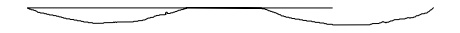

In [206]:
load_img(p1)

In [207]:
len(a2[1])

32

In [31]:
a2[1]

array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 1, 0])

# Test BalancedPairsGeneratorFromImages in image_generators.py

In [2]:
# Add the project dir and the src folder to paths
import sys
from pathlib import Path
project_dir = Path.cwd().parent
src_dir = project_dir / 'Notebooks/src'
sys.path.insert(0, str(project_dir))
sys.path.insert(0, str(src_dir))
src_dir

WindowsPath('C:/VuNguyen/Study/Capgemini data science challenge 2020/Notebooks/src')

In [3]:
#import argparse
#import logging
#import os
#import pathlib
from data.image_generators import BalancedDataGeneratorFromImages, BalancedPairsGeneratorFromImages

from itertools import combinations
import math

In [4]:
#train_path='../experiments/13.2. tuning_edges_notch_underwater/train/'
train_path='../experiments/13.3.tuning_edges_new_train_data/train/'
t3=BalancedPairsGeneratorFromImages(train_path)

In [5]:
a3=t3.get_sample(439)

7024 7040 7261 7261


In [9]:
t3.on_epoch_end()

2 14522 21783


In [10]:
t3.get_sample(453)

7248 7264 7261 7261


([array([[[[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.]],
  
          [[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.]],
  
          [[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.]],
  
          ...,
  
          [[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.]],
  
          [[255., 255., 255.],
           [255., 255., 255.],
           [255., 255., 255.],
           ...,
           [255., 255., 255.],
           [255., 

In [13]:
t3.get_sample(453)[1]

7248 7264 7261 7261


array([      1,       0,       1,       0,       1,       0,       1,
             0,       1,       0,       1,       0,       1,       0,
             1,       0,       1,       0,       1,       0,       1,
             0,       1,       0,       1,       0, 2490416, 3145776,
       3145776, 3145776,       0,     606])